<h4 align="right">Orestis Charalambous</h4> 
<h4 align="right">Elif Naz Bozkurt</h4> 
<h1><center><font size="50">Task 3</font></center></h1>

## Contents
* [1. CartPole-v0 environment](#1)
    * [1.1. Proximal Policy Optimization Reinforcement Learning algorithm](#1.1)
    * [1.2 PPO Memory](#1.2)
    * [1.3 Neural Network ](#1.3)
        * [1.3.1 Actor Network ](#1.3.1)
        * [1.3.2 Critic Network ](#1.3.2)
    * [1.4 PPO Agent ](#1.4) 
    * [1.5 Training ](#1.5)
    * [1.6. Evaluation and Results ](#1.6)
    


## 1. CartPole-v0 an OpenAI Gym environment <a class="anchor" id="1"></a>

![image.png](https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/CartPole-v1/poster.jpg)


A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

The state space has 4 dimensions and contains the cart position, velocity, pole angle and pole velocity.

### Actions

Two discrete actions are available, corresponding to:

- 0 :     Push cart to the left
- 1 :     Push cart to the right

### Rewards

A reward of +1 is given for every step taken, and a reward of 0 is provided at the termination step. 

[For more information about the CartPole-v0 environment](https://github.com/openai/gym/wiki/CartPole-v0)


### 1.1. Proximal Policy Optimization Reinforcement Learning algorithm <a class="anchor" id="1.1"></a>

In this task we will train an agent for the CartPole-v0 (OpenAI Gym) environment via PPO algorithm.

Our network is going to output probabilities using a soft max activation with tanh and ReLu for a categorical distirbution in PyTorch. 

### Imporing Libraries

In [1]:
import numpy as np
import gym
import torch
from torch import nn
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import seaborn as sns

%matplotlib inline

# Customising style for Graphs
plt.style.use(['ggplot'])
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['grid.color']='#dcdcdc'
plt.rcParams['axes.facecolor']='white'
mpl.rcParams['font.size'] = 15
cmap = sns.diverging_palette(220, 10, as_cmap=True)

### 1.2. PPO Memory <a class="anchor" id="1.2"></a>

Setting torch device and memory class for storing action, states, old probability, next state probability, rewards and done. This is done so our agent trains by choosing the best probability at that stage.

In [2]:
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()


class PPO_Memory:
    def __init__(self, batch_size):
        self.states = []
        self.logprobs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.is_done = []

        self.batch_size = batch_size

    def generate_batches(self):
        make_batch = np.arange(0, len(self.states), self.batch_size)
        indices = np.arange(len(self.states), dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i + self.batch_size] for i in make_batch]

        return np.array(self.states), \
               np.array(self.actions), \
               np.array(self.logprobs), \
               np.array(self.vals), \
               np.array(self.rewards), \
               np.array(self.is_done), \
               batches

    def store(self, state, action, logprobs, vals, reward, is_done):
        self.states.append(state)
        self.actions.append(action)
        self.logprobs.append(logprobs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.is_done.append(is_done)

    def clear_memory(self):
        del self.states[:]
        del self.logprobs[:]
        del self.actions[:]
        del self.rewards[:]
        del self.is_done[:]
        del self.vals[:]

### 1.3. Neural Networks <a class="anchor" id="1.3"></a>

#### 1.3.1 Actor Network <a class="anchor" id="1.3.1"></a>

The Actor decides what to do based on current state.

The Critic evaluates the states that the agent encounters, it criticise the decisions that the actor makes based on the states it ends up in.


**Note**: Change nn.RelU() to nn.tanh() for both networksreports result.


In [3]:
class Actor(nn.Module):
    def __init__(self, n_actions, input_dims):
        super().__init__()

        self.actor = nn.Sequential(
            nn.Linear(*input_dims, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        dist = self.actor(state)


        return dist

#### 1.3.2. Critic Network <a class="anchor" id="1.3.2"></a>

In [4]:
class Critic(nn.Module):
    def __init__(self, input_dims):
        super().__init__()

        self.critic = nn.Sequential(
            nn.Linear(*input_dims, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        value = self.critic(state)

        return value

 ### 1.4. PPO Agent <a class="anchor" id="1.4"></a>

In [5]:
class PPO_Agent:
    def __init__(self, n_actions, input_dims, gamma, batch_size, alpha, lmbda,
                 eps_clip, num_epochs):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.num_epochs = num_epochs
        self.lmbda = lmbda

        self.actor = Actor(n_actions, input_dims)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=alpha)

        self.critic = Critic(input_dims)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=alpha)

    def choose_action(self, observation):
        state = torch.tensor([observation], dtype=torch.float32).to(device)

        dist = Categorical(self.actor(state))
        value = self.critic(state)
        action = dist.sample()

        prob_act = dist.log_prob(action)
        action = torch.squeeze(action)
        value = torch.squeeze(value)

        return action.item(), prob_act.item(), value.item()

    def actor_loss(self, state, action, old_prob, advantage, clip_ratio):

        dist = Categorical(self.actor(state))
        ratio = (dist.log_prob(action) - old_prob).exp()
        clip_adv = torch.clamp(ratio, 1 - clip_ratio, 1 + clip_ratio) * advantage
        loss_pi = -torch.min(ratio * advantage, clip_adv)

        return loss_pi

    def critic_loss(self, state, advantage, values):

        critic_value = torch.squeeze(self.critic(state))
        critic_value = torch.squeeze(critic_value)
        returns = advantage + values
        critic_loss = (returns - critic_value) ** 2

        return critic_loss

    def update(self, memory):
        for _ in range(self.num_epochs):
            #Generating batches arrays
            state_, action_, old_prob_, next_state, reward_, is_done_, batches = memory.generate_batches()

            advantage = np.empty(len(reward_), dtype=np.float32)

            for t in range(len(reward_) - 1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_) - 1):
                    a_t += discount * (reward_[k] + self.gamma * next_state[k + 1] * \
                                       (1 - int(is_done_[k])) - next_state[k])
                    discount *= self.gamma * self.lmbda
                advantage[t] = a_t
            advantage = torch.tensor(advantage, dtype=torch.float32).to(device).detach()

            next_state = torch.tensor(next_state, dtype=torch.float32).to(device).detach().detach()
            for batch in batches:
                states = torch.tensor(state_[batch], dtype=torch.float32).to(device).detach()
                old_prob = torch.tensor(old_prob_[batch], dtype=torch.float32).to(device).detach()
                actions = torch.tensor(action_[batch], dtype=torch.float32).to(device).detach()

                actor_loss = self.actor_loss(states, actions, old_prob, advantage[batch], self.eps_clip)
                critic_loss = self.critic_loss(states, advantage[batch], next_state[batch])
                total_loss = actor_loss + 0.5 * critic_loss
                
                self.actor_optimizer.zero_grad()
                self.critic_optimizer.zero_grad()
                total_loss.mean().backward()
                self.actor_optimizer.step()
                self.critic_optimizer.step()


### Initialising environment

In [6]:
env = gym.make('CartPole-v0')

### 1.5. Training <a class="anchor" id="1.5"></a>

In [7]:
n_actions = env.action_space.n
input_dims = env.observation_space.shape

# Parameters
update_timestep = 20
batch_size = 5
num_epochs = 4
alpha = 0.0003
gamma = 0.99
lmbda = 0.95
eps_clip = 0.1


# Creating classes
agent = PPO_Agent(n_actions, input_dims, gamma, batch_size, alpha, lmbda, eps_clip, num_epochs)
memory = PPO_Memory(batch_size)


n_episodes = 0
episode_rewards = []
SHOW_EVERY = 20
learn_iters = 0
avg_score = 0
n_step = 0
time_steps = 0


print("------------------------------------------------Training the agent------------------------------------------------")

end = False
while not end:
    state = env.reset()    # Current State
    done = False
    c_reward = 0          # Cum reward
    episode_length = 0
    n_episodes += 1
    
    while not done:
        n_step += 1
        episode_length +=1
        
        action, prob, val = agent.choose_action(state)
        observation, reward, done, _ = env.step(action)
        
        memory.store(state, action, prob, val, reward, done)
        c_reward += reward
        # Update if its time
        if n_step % update_timestep == 0:
            agent.update(memory)
            memory.clear_memory()
            n_step = 0
        time_steps += 1
        state = observation
    episode_rewards.append(c_reward)
    avg_score = np.mean(episode_rewards[-SHOW_EVERY:])
    

    #Logging
    if n_episodes % SHOW_EVERY == 0:
        print("Episode #{}  \tScore: {:.1f}  \tLast episode length: {:.2f}   \tTime step: {}   "
              "\tMean reward of last 20 episodes: {:.2f}".format(n_episodes, c_reward, episode_length, time_steps, avg_score))
    elif np.mean(episode_rewards[-100:]) > 195:
        end = True

print("------------------------------------------Training complete------------------------------------------")
print("--------------------------------Mean Reward: {:.2f}\t for {} episodes--------------------------------".format(np.mean(episode_rewards), n_episodes))

------------------------------------------------Training the agent------------------------------------------------
Episode #20  	Score: 43.0  	Last episode length: 43.00   	Time step: 487   	Mean reward of last 20 episodes: 24.35
Episode #40  	Score: 30.0  	Last episode length: 30.00   	Time step: 1284   	Mean reward of last 20 episodes: 39.85
Episode #60  	Score: 83.0  	Last episode length: 83.00   	Time step: 2746   	Mean reward of last 20 episodes: 73.10
Episode #80  	Score: 166.0  	Last episode length: 166.00   	Time step: 5464   	Mean reward of last 20 episodes: 135.90
Episode #100  	Score: 200.0  	Last episode length: 200.00   	Time step: 8090   	Mean reward of last 20 episodes: 131.30
Episode #120  	Score: 198.0  	Last episode length: 198.00   	Time step: 11646   	Mean reward of last 20 episodes: 177.80
Episode #140  	Score: 200.0  	Last episode length: 200.00   	Time step: 15646   	Mean reward of last 20 episodes: 200.00
Episode #160  	Score: 200.0  	Last episode length: 200.00

### 1.6. Evaluation and results <a class="anchor" id="1.6"></a>

Text(0.5, 1.0, 'Moving Average')

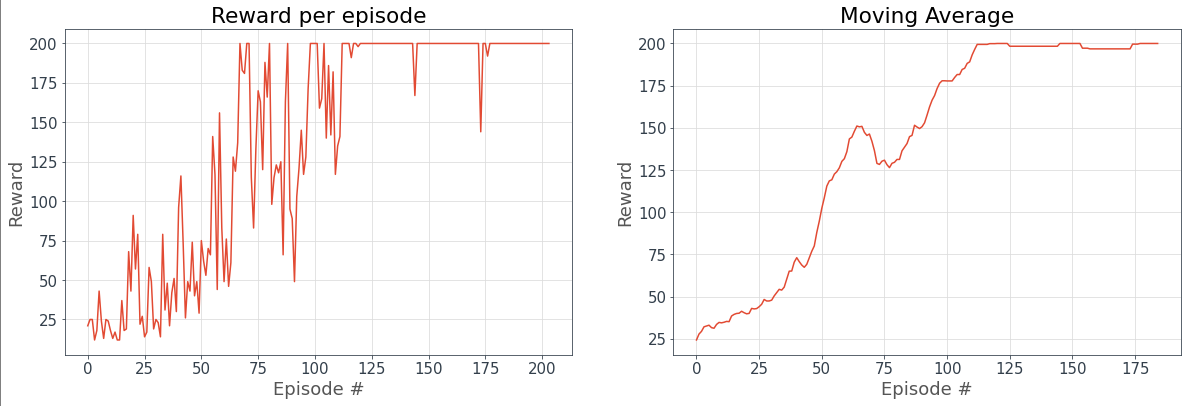

In [8]:
plt.figure(figsize=(20, 6), linewidth=1)
plt.subplot(1,2,1)
plt.plot([i for i in range(n_episodes)], [i for i in episode_rewards])
plt.ylabel("Reward")
plt.xlabel("Episode #")
plt.title("Reward per episode")

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,)) / SHOW_EVERY, mode="valid")
plt.subplot(1,2,2)
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel("Reward")
plt.xlabel("Episode #")
plt.title("Moving Average")